# Data loader

In [1]:

import os.path as osp
from PIL import Image

import torch.utils.data as data

# 이미지 데이터, 주석 데이터에 대한 파일 경로 목록 만들기

In [3]:

def make_datapath_list(rootpath):
    """
    학습, 검증 이미지 데이터 및 주석 데이터에 대한 파일 경로 목록을 만듭니다.
    
    Parameters
    ----------
    rootpath : str
        데이터 폴더 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 포함하는 목록
    """

    # 이미지 및 주석 파일에 대한 경로 템플릿 만들기
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 교육 및 검증, 각 파일의 ID(파일 이름)를 얻습니다.
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 교육 데이터의 이미지 및 주석 파일에 대한 경로 목록 만들기
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 빈 공간과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 유효성 검사 데이터의 이미지 및 주석 파일에 대한 경로 목록 만들기
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [5]:
# 동작 확인 파일 경로 목록 얻기
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


# Dataset

In [8]:
#데이터 처리 클래스와 데이터 조정 클래스를 가져옵니다.
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor


class DataTransform():
    """
    이미지 및 어노테이션의 전처리 클래스. 훈련시와 검증시에 다른 동작을 한다.
    이미지의 크기를 input_size x input_size로 설정합니다.
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 이미지 확대
                RandomRotation(angle=[-10, 10]),  # 회전
                RandomMirror(),  # 랜덤 미러
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색 정보의 표준화와 텐서화
            ]),
            'val': Compose([
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색 정보의 표준화와 텐서화
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정합니다.
        """
        return self.data_transform[phase](img, anno_class_img)


In [9]:
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 작성하는 클래스. PyTorch의 Dataset 클래스를 상속.
    
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''이미지 수를 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리 된 이미지의 Tensor 형식 데이터 및 주석 얻기
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''이미지의 Tensor 형식 데이터, 주석 얻기'''

        # 1. 이미지 로드
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [높이][폭][RGB]

        # 2. 어노테이션 이미지 불러오기
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [높이][폭]

        # 3. 전처리 실시
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img


In [10]:
# 동작 확인

# (RGB)색상의 평균값과 표준 편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# 데이터 세트 작성
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# 데이터 검색 예
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))


torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.2043,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.2043,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.2043,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3256,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3256,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3256,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

# DataLoader만들기

In [11]:
# 데이터 로더 만들기

batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # 이터레이터로 변환
imges, anno_class_imges = next(batch_iterator)  # 다음 요소 검색
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])


torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


以上

# （부록）Dataset 이미지 그리기

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## 훈련 이미지 그리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


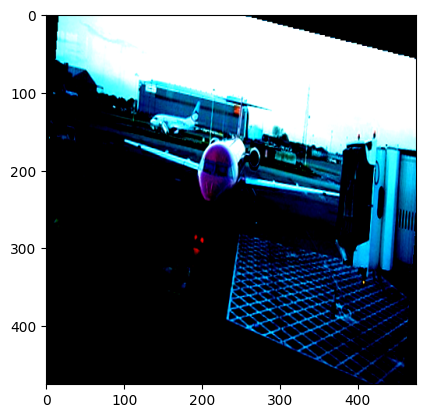

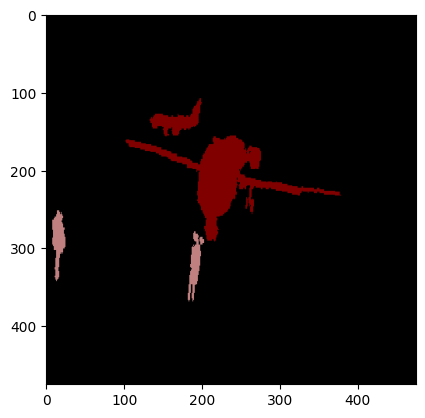

In [13]:
# 실행할 때마다 변경

# 이미지 데이터 불러오기
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 이미지 표시
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# 어노테이션 이미지 표시
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭][RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


## 검증 이미지 그리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


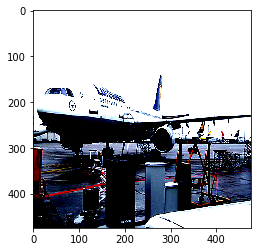

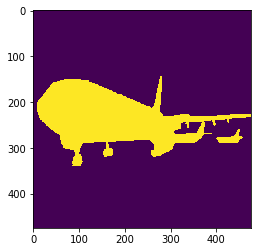

In [12]:
# 이미지 데이터 불러오기
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 이미지 데이터 불러오기
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# 어노테이션 이미지 표시
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭][RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


以上